In [1]:
import slideio
import cv2
import moco.builder
import moco.loader
import torch
import torch.nn as nn
from torchvision import transforms
import numpy as np
import json
import vits
import matplotlib.pyplot as plt


from models.dsmil import MILNet, FCLayer, BClassifier
from tqdm.notebook import tqdm
from collections import OrderedDict
from functools import partial

In [2]:
def get_patch_for_size(slide_handler, size):
    scene_0 = slide_handler.get_scene(0)
    resolutions = scene_0.resolution
    patch_size_x = int(size[0]/resolutions[0])
    patch_size_y = int(size[1]/resolutions[1])
    return (patch_size_x, patch_size_y)

class PatchGenerator:
    def __init__(self, slide_path):
        self.slide_path = slide_path
    
    @staticmethod
    def fetch_avg_saturation(image):
        blurred_image = cv2.GaussianBlur(image, (5,5), 0)
        hsv_image = cv2.cvtColor(blurred_image, cv2.COLOR_RGB2HSV)
        return np.mean(hsv_image[:,:,1])

    @staticmethod
    def get_patch_for_size(slide_handler, size):
        scene_0 = slide_handler.get_scene(0)
        resolutions = scene_0.resolution
        patch_size_x = int(size[0]/resolutions[0])
        patch_size_y = int(size[1]/resolutions[1])
        return (patch_size_x, patch_size_y)
    
    @staticmethod
    def patch_generator_with_precision_scale(image_path, size_to_fetch=(0.0003861256, 0.0003861256),
                                         final_size=224, min_saturation=10,
                                         non_blur_thresh=None):
        slide_handler = slideio.open_slide(image_path, 'SVS')
        scene = slide_handler.get_scene(0)

        actual_size = scene.size
        actual_width = actual_size[0]
        actual_height = actual_size[1]

        patch_size = PatchGenerator.get_patch_for_size(slide_handler, size_to_fetch)

        patch_x = patch_size[0]
        patch_y = patch_size[1]

        width_to_use = 10*actual_width//patch_x
        smaller_image = scene.read_block(size=(width_to_use,0))
        copied_image = scene.read_block(size=(width_to_use,0))
        smaller_width = np.shape(smaller_image)[1]
        smaller_height = np.shape(smaller_image)[0]

        smaller_patch_size_x = patch_x*smaller_width//actual_width
        smaller_patch_size_y = patch_y*smaller_height//actual_height

        positions = []

        avg_saturation_is_ok = False
        while not avg_saturation_is_ok:
            positions = []
            all_saturations = []
            current_x = 0
            current_y = 0
            while current_y <= actual_height:
                while current_x <= actual_width:
                    small_current_y = (current_y * smaller_height)//actual_height
                    small_current_x = (current_x * smaller_width)//actual_width

                    bottom_border = small_current_y + smaller_patch_size_y
                    right_border = small_current_x + smaller_patch_size_x

                    if bottom_border > smaller_height:
                        bottom_border = smaller_height
                    if right_border > smaller_width:
                        right_border = smaller_width

                    sub_image = smaller_image[small_current_y:bottom_border, 
                                              small_current_x:right_border]
                    saturation = PatchGenerator.fetch_avg_saturation(sub_image)

                    if saturation > min_saturation:
                        non_blur = 10000000000000000
                        if non_blur_thresh is not None:
                            non_blur = get_laplacian_variance(sub_image)
                        if (non_blur_thresh is None) or (non_blur > non_blur_thresh):
                            all_saturations.append(saturation)
                            positions.append((current_x, current_y))
                    current_x += patch_x
                current_y += patch_y
                current_x = 0
            avg_saturation = np.mean(all_saturations)
            if avg_saturation < min_saturation * 3:
                min_saturation = min_saturation / 2
            else:
                avg_saturation_is_ok = True

        num_positions = len(positions)
        for i, position in tqdm(enumerate(positions), total=num_positions):
            try:
                x1 = position[0]
                y1 = position[1]
                width = min(patch_x, actual_width - x1)
                height = min(patch_y, actual_height - y1)
                normalized_position = (x1//patch_x, y1//patch_y)

                sub_image = scene.read_block((x1, y1, width, height), (final_size, final_size))
                yield normalized_position, sub_image
            except BaseException as e:
                print('erro no yield: ' + str(e), image_path)
                pass
            
    def get_patch_gen(self):
        return PatchGenerator.patch_generator_with_precision_scale(self.slide_path)

In [21]:
def make_blue_matrix(raw_matrix):
    blue_matrix = np.zeros((raw_matrix.shape[0], raw_matrix.shape[1], 3))
    for i in range(raw_matrix.shape[0]):
        for j in range(raw_matrix.shape[1]):
            blue_matrix[i][j][0] = 255
    return blue_matrix.astype(np.uint8)

class InferenceOnlyMocoV3(nn.Module):
    def __init__(self, mocov3_model):
        super().__init__()
        self.mocov3_model = mocov3_model
    
    def forward(self, x):
        return self.mocov3_model.base_encoder(x)

class HeatmapMaker:
    FEAT_GEN = None
    
    def __init__(self, model):
        self.model = model

    @staticmethod
    def get_small_grid_from_slide(image_path, size_to_fetch=(0.0003861256, 0.0003861256), is_rgb=False):
        
        slide_handler = slideio.open_slide(image_path, 'SVS')
        patch_size = get_patch_for_size(slide_handler, size_to_fetch)
        scene = slide_handler.get_scene(0)

        actual_size = scene.size
        actual_width = actual_size[0]
        actual_height = actual_size[1]

        width_to_use = actual_width//patch_size[0]
        smaller_image = scene.read_block(size=(width_to_use,0))

        smaller_width = np.shape(smaller_image)[1]
        smaller_height = np.shape(smaller_image)[0]
        
        if is_rgb:
            return np.zeros((smaller_height, smaller_width, 3), dtype=np.float32)
        return np.zeros((smaller_height, smaller_width), dtype=np.float32)

    @staticmethod
    def adjust_keys(state_dict):
        new_state_dict = OrderedDict()
        for key in state_dict:
            if key.startswith('module.'):
                new_key = key.replace('module.', '')
                new_state_dict[new_key] = state_dict[key]
        return new_state_dict
    
    @staticmethod
    def load_mocov3():
        base_encoder = torch.load(r'./vit_small.pth.tar')['state_dict']
        corrected_base_encoder = HeatmapMaker.adjust_keys(base_encoder)

        model = moco.builder.MoCo_ViT(
                    partial(vits.__dict__['vit_small'], stop_grad_conv1=True))
        model.load_state_dict(corrected_base_encoder, strict=True)

        model.eval()
        model.cuda()

        return InferenceOnlyMocoV3(model)
    
    @staticmethod
    def correct_img(patches):  # Expects the patches to come in the cropped size, 299
        img_transform = transforms.Compose([transforms.Resize(224),
                                       transforms.Normalize(mean=(0.485, 0.456, 0.406),
                                                            std=(0.229, 0.224, 0.225))])
        t = torch.stack([img_transform(torch.from_numpy(img).permute(2, 0, 1).float() / 255.0) for img in patches])
        t = t.to(torch.device('cuda'))
        return t

    @staticmethod
    def fetch_feature_array(patch):
        if HeatmapMaker.FEAT_GEN is None:
            HeatmapMaker.FEAT_GEN = HeatmapMaker.load_mocov3()
        input_t = HeatmapMaker.correct_img(np.array([patch]))
        raw_output = HeatmapMaker.FEAT_GEN(input_t)
        main_size = raw_output.shape[1]
        out_np = raw_output.cpu().detach()
        del input_t
        del raw_output
        return torch.reshape(out_np, [-1,main_size])
    
    @staticmethod
    def build_final_tensor(feature_arrays):
        return torch.vstack(feature_arrays)
    
    @staticmethod
    def generate_tensor_from_slide(slide_path):
        patch_gen = PatchGenerator(slide_path).get_patch_gen()
        feat_arrays = []
        positions = []
        coords = []
        for pos, patch in patch_gen:
            coords.append(patch)
            new_feats = HeatmapMaker.fetch_feature_array(patch)
            feat_arrays.append(new_feats)
            positions.append(pos)
        return positions, HeatmapMaker.build_final_tensor(feat_arrays)
    
    @staticmethod
    def inference_and_attentions(model, raw_feats, thresh_c0=0.5, thresh_c1=0.5, num_classes=1):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.eval()
        feats_list = []
        classes_list = []

        with torch.no_grad():
            raw_feats = raw_feats.to(device, non_blocking = True)
            feats, classes = model.i_classifier(raw_feats)
            feats = feats.cpu().numpy()
            classes = classes.cpu().numpy()
            feats_list.extend(feats)
            classes_list.extend(classes) 
            feats_arr = np.vstack(feats_list)
            classes_arr = np.vstack(classes_list)
            bag_feats = torch.from_numpy(feats_arr).cuda()
            ins_classes = torch.from_numpy(classes_arr).cuda()


            bag_prediction, A, _ = model.b_classifier(bag_feats, ins_classes)
            bag_prediction = torch.sigmoid(bag_prediction).squeeze().cpu().numpy() 

            if num_classes == 1:
                attentions = A

            else:
                if bag_prediction[0] >= thresh_c0 and bag_prediction[1] < thresh_c1:
                    attentions = A[:, 0]
                elif bag_prediction[1] >= thresh_c0 and bag_prediction[0] < thresh_c1:
                    attentions = A[:, 1]            
                elif bag_prediction[0] < thresh_c0 and bag_prediction[1] < thresh_c1:
                    attentions = []
                else:
                    attentions = []

            if len(attentions) != 0:
                attentions = attentions.cpu().numpy()

        return bag_prediction, attentions, classes_arr
    
    @staticmethod
    def read_small_slide_image(image_path, desired_width):
        slide = slideio.open_slide(image_path, 'SVS')
        scene = slide.get_scene(0)
        image = scene.read_block(size=(desired_width,0))
        return image

    def make_image_heatmap(self, slide_path, quantile=0.5):
        heatmap_matrix = HeatmapMaker.get_small_grid_from_slide(slide_path)
        positions, input_tensor = HeatmapMaker.generate_tensor_from_slide(slide_path)
        out_model,  att, classes = HeatmapMaker.inference_and_attentions(model, input_tensor)
        """max_score = np.max(att)
        min_score = np.min(att)
        scores = (att - min_score)/(max_score - min_score)
        thresh = np.quantile(scores, quantile)"""
        
        max_score = np.max(classes)
        min_score = np.min(classes)
        scores = (classes - min_score)/(max_score - min_score)
        s1, s2 = heatmap_matrix.shape
        for idx in range(len(positions)):
            score = scores[idx]
            coord = positions[idx]
            #if score > thresh:
            heatmap_matrix[min(coord[1], s1-1), min(coord[0], s2-1)] = score#classes[idx]#score
            #else: 
            #heatmap_matrix[min(coord[1], s1-1), min(coord[0], s2-1)] = 0
        return heatmap_matrix, classes
    
    @staticmethod
    def show_map(slide_path, heatmap, desired_width = 4096*3, quantile=0.5):
        raw_img = HeatmapMaker.read_small_slide_image(slide_path, desired_width = desired_width)
        img_shape = np.shape(raw_img)
        desired_shape = (img_shape[1], img_shape[0])
        resized_heatmap = cv2.resize(heatmap, desired_shape, interpolation = cv2.INTER_LINEAR) 
        int_resized_heatmap = (255.0*resized_heatmap).astype(np.uint8)
        thresh = np.quantile(int_resized_heatmap, quantile)
        opacity_img = cv2.cvtColor(((int_resized_heatmap > thresh)*255).astype(np.uint8), cv2.COLOR_GRAY2RGB)
        heatmap_colored = cv2.applyColorMap(int_resized_heatmap, cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        heatmap_colored = cv2.bitwise_and(heatmap_colored, opacity_img)
        super_imposed_img = cv2.addWeighted(heatmap_colored, 0.9, raw_img, 1.0, 0)

        fig = plt.figure()
        plt.imshow(super_imposed_img)
        plt.savefig('heatmap.png', dpi=300)
        plt.show(block=False)

In [4]:
ls *.json

 O volume na unidade C é OS
 O Número de Série do Volume é 1299-FF61

 Pasta de C:\Users\danie\Documents\OncoData_roraima\dsmil_stomach

19/02/2024  20:57           178.769 stomach_json.json
19/02/2024  20:58            55.452 stomach_json_test.json
19/02/2024  20:58           123.320 stomach_json_train.json
               3 arquivo(s)        357.541 bytes
               0 pasta(s)   139.080.843.264 bytes disponíveis


In [5]:
INPUT_JSON = json.loads(open('stomach_json_test.json', 'r').read())

In [6]:
INPUT_JSON[0]

{'image_tag': 'Primary Tumor',
 'image_path': 'D:\\Stomach_tissue\\b8c9be9b-af38-4513-91ac-aaeca74ddbf0\\TCGA-CD-8532-01A-01-TS1.ee90c932-1579-4b59-a184-2179bcc38c79.svs',
 'dataset': 'Primary Tumor',
 'participant': '8532',
 'size_gb': 0.131683999,
 'size_img': [37849, 37996]}

In [7]:
ls *.pt

 O volume na unidade C é OS
 O Número de Série do Volume é 1299-FF61

 Pasta de C:\Users\danie\Documents\OncoData_roraima\dsmil_stomach

20/02/2024  17:36           203.352 seed_3797.pt
               1 arquivo(s)        203.352 bytes
               0 pasta(s)   139.080.843.264 bytes disponíveis


In [8]:
FEATS_SIZE = 256
NUM_CLASSES = 1
MODEL='seed_3797.pt'

In [9]:
def load_dsmil(feats_size, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    i_classifier = FCLayer(in_size=feats_size, out_size=num_classes).to(device)
    b_classifier = BClassifier(input_size=feats_size, output_class=num_classes, dropout_v = 0., nonlinear = 1).to(device)
    return MILNet(i_classifier, b_classifier).to(device)

In [10]:
model = load_dsmil(FEATS_SIZE, NUM_CLASSES)
model.load_state_dict(torch.load(MODEL)['model_state_dict'])
model.eval()

MILNet(
  (i_classifier): FCLayer(
    (fc): Sequential(
      (0): Linear(in_features=256, out_features=1, bias=True)
    )
  )
  (b_classifier): BClassifier(
    (q): Sequential(
      (0): Linear(in_features=256, out_features=128, bias=True)
      (1): ReLU()
      (2): Linear(in_features=128, out_features=128, bias=True)
      (3): Tanh()
    )
    (v): Identity()
    (fcc): Conv1d(1, 1, kernel_size=(256,), stride=(1,))
  )
)

In [31]:
heatmap, classes = HeatmapMaker(model).make_image_heatmap(INPUT_JSON[100]['image_path'])

  0%|          | 0/363 [00:00<?, ?it/s]

In [12]:
np.shape(classes)

(363, 1)

In [13]:
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [18]:
heatmap

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<Figure size 640x480 with 0 Axes>

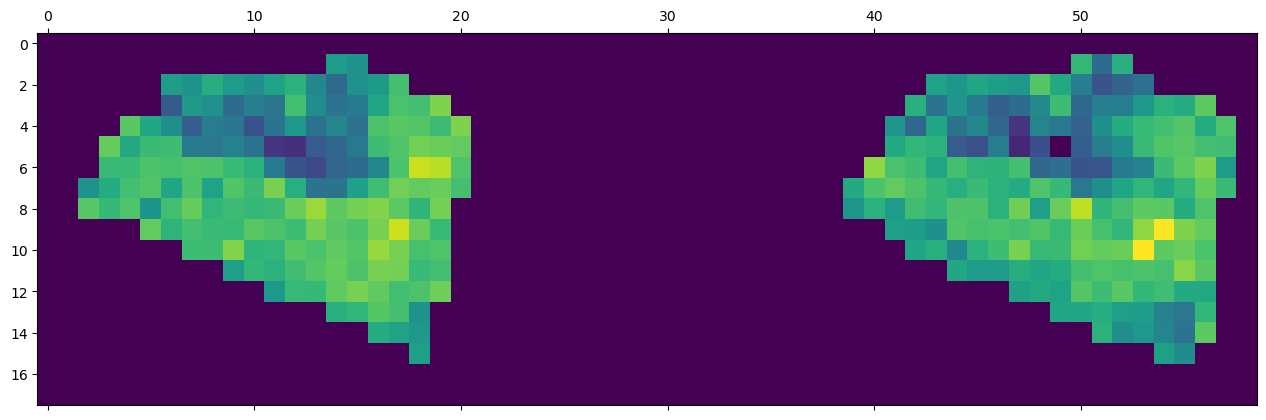

In [32]:
plt.figure()
plt.matshow(heatmap)
plt.show()

In [14]:
%matplotlib notebook

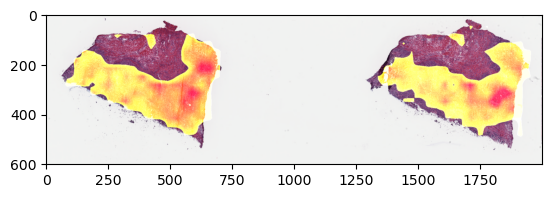

In [34]:
HeatmapMaker.show_map(INPUT_JSON[100]['image_path'], heatmap, desired_width = 2000, quantile=0.8)

In [82]:
INPUT_JSON[100]

{'image_tag': 'Primary Tumor',
 'image_path': 'D:\\Stomach_tissue\\c4fae759-ef05-45bc-969b-b9f0d88868c4\\TCGA-D7-A6EZ-01A-01-TS1.80EA7318-C520-4E4E-B6ED-40E2B09DA129.svs',
 'dataset': 'Primary Tumor',
 'participant': 'A6EZ',
 'size_gb': 0.310936637,
 'size_img': [93296, 28016]}

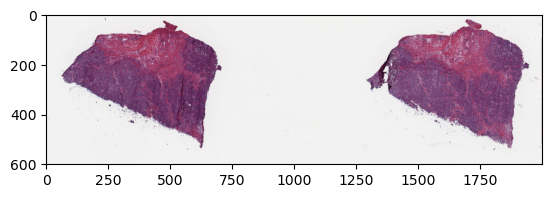

In [36]:
raw = HeatmapMaker.read_small_slide_image(INPUT_JSON[100]['image_path'], 2000)

plt.figure()
plt.imshow(raw)
plt.savefig('raw.png', dpi=300)
plt.show()